In [1]:
import sqlalchemy
import sqlite3

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# engine = sqlalchemy.create_engine('sqlite:///mental_health.sqlite')
con = sqlite3.connect("mental_health.sqlite")

# load prev installed sql module
%load_ext sql
%sql sqlite:///mental_health.sqlite

In [133]:
%%sql

DROP VIEW IF EXISTS YesTechEmployer;
CREATE VIEW YesTechEmployer AS
SELECT Answer.UserID
FROM Question JOIN Answer ON (Question.QuestionID=Answer.QuestionID)
WHERE Question.questiontext="Is your employer primarily a tech company/organization?" 
    AND Answer.AnswerText=1;
    
    
DROP VIEW IF EXISTS AnswerTechEmployer;
CREATE VIEW AnswerTechEmployer AS
SELECT CAST(Answer.AnswerText AS int) AS TechEmployerAnswer, Answer.UserID
FROM Question JOIN Answer ON (Question.QuestionID=Answer.QuestionID)
WHERE Question.questiontext="Is your employer primarily a tech company/organization?";

 * sqlite:///mental_health.sqlite
Done.
Done.
Done.
Done.


[]

In [2]:
%%sql

SELECT * FROM AnswerTechEmployer
LIMIT 10

 * sqlite:///mental_health.sqlite
Done.


TechEmployerAnswer,UserID
-1,1264
-1,1270
-1,1279
-1,1285
-1,1294
-1,1301
-1,1304
-1,1307
-1,1309
-1,1313


In [178]:
# for employees of tech companies/organizations, how easy it is to take a medical leave for a mental health condition
df_query1 = pd.read_sql_query("""
    SELECT QuestionText AS 'Question', AnswerText AS 'Answer', count(AnswerText) AS 'Number of Responses' 
    FROM Question JOIN Answer ON (Question.QuestionID=Answer.QuestionID)
    WHERE Question.QuestionText IN 
        ("How easy is it for you to take medical leave for a mental health condition?")
        AND Answer.UserID IN (SELECT * FROM YesTechEmployer)
        AND AnswerText NOT LIKE '%don%t know%'
    GROUP BY Answer.AnswerText
    ORDER BY count(AnswerText) DESC
    """, con)

df_query1

,Question,Answer,Number of Responses
0,How easy is it for you to take medical leave f...,Somewhat easy,219
1,How easy is it for you to take medical leave f...,Very easy,179
2,How easy is it for you to take medical leave f...,Somewhat difficult,98
3,How easy is it for you to take medical leave f...,Very difficult,79


Text(0.5,1,'As an employee of a tech company, how easy to take medical leave for a mental health condition?')

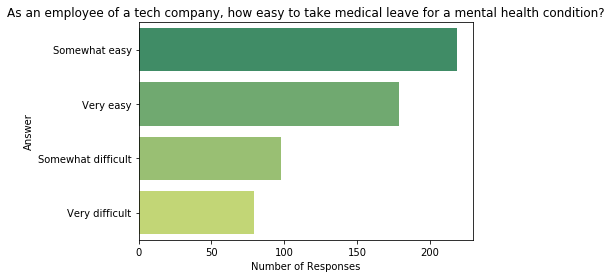

In [180]:
plot_query1 = sns.barplot('Number of Responses', 'Answer', data=df_query1, palette="summer")
plot_query1.set_title("As an employee of a tech company, how easy to take medical leave for a mental health condition?")

In [181]:
df_query1b = pd.read_sql_query("""
    SELECT AnswerText AS EaseMedicalLeave, TechEmployerAnswer, count(AnswerText) AS Count
    FROM Question JOIN Answer ON (Question.QuestionID=Answer.QuestionID)
    JOIN AnswerTechEmployer ON (AnswerTechEmployer.UserID=Answer.UserID)
    WHERE Question.QuestionText IN 
            ("How easy is it for you to take medical leave for a mental health condition?")
        AND AnswerText LIKE '%easy' 
        OR AnswerText LIKE '%difficult'
        GROUP BY AnswerText, TechEmployerAnswer
        HAVING Count>10
    """, con)

df_query1b

,EaseMedicalLeave,TechEmployerAnswer,Count
0,Difficult,0,43
1,Difficult,1,69
2,Neither easy nor difficult,0,99
3,Neither easy nor difficult,1,245
4,Somewhat difficult,0,136
5,Somewhat difficult,1,348
6,Somewhat easy,0,47
7,Somewhat easy,1,219
8,Very difficult,0,57
9,Very difficult,1,159


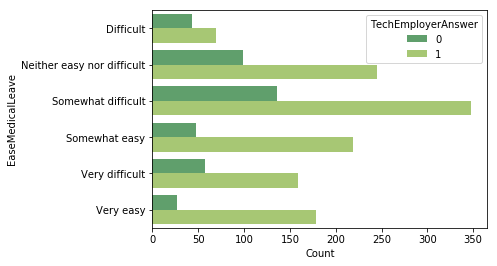

In [182]:
plot_query1b = sns.barplot('Count', 'EaseMedicalLeave', hue='TechEmployerAnswer', data=df_query1b, palette="summer")

In [92]:
# for employees of tech companies/organizations, 
#     do you think discussing a mental health issue with your employer would have negative consequences?
df_query2 = pd.read_sql_query("""
    SELECT QuestionText AS 'Question', AnswerText AS 'Answer', count(AnswerText) AS 'Number of Responses' 
    FROM Question JOIN Answer ON (Question.QuestionID=Answer.QuestionID)
    WHERE Question.QuestionText IN 
        ("Do you think that discussing a mental health issue with your employer would have negative consequences?")
        AND Answer.UserID IN (SELECT * FROM YesTechEmployer)
    GROUP BY Answer.AnswerText
    """, con)

df_query2

,Question,Answer,Number of Responses
0,Do you think that discussing a mental health i...,Maybe,376
1,Do you think that discussing a mental health i...,No,430
2,Do you think that discussing a mental health i...,Yes,225


Text(0.5,1,'Do you think discussing mental health issues with your tech employer would have negative consequences?')

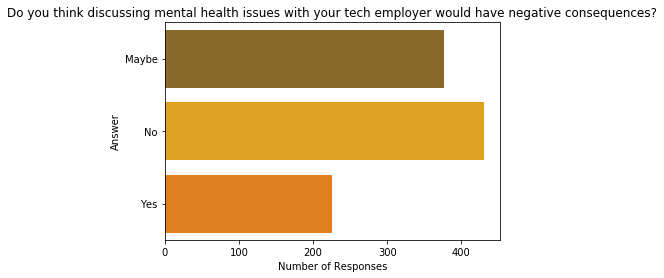

In [94]:
plot_query2 = sns.barplot('Number of Responses', 'Answer', data=df_query2, palette="autumn_d")
plot_query2.set_title("Do you think discussing mental health issues with your tech employer would have negative consequences?")